In [515]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
from __future__ import division
import csv
import math
import powerlaw
from numpy import genfromtxt
import random
import pandas as pd

## Change filename of other mode of travel

In [516]:
railonly_file_path = 'railonly.csv'

## Heatwave scenario can be changed as well

In [517]:
#df_heatwave = pd.read_csv("hot_days_per_year.csv")
df_heatwave = pd.read_csv("hot_days_daily.csv")
df_heatwave_select = df_heatwave[["dms_orig_string","hot_days_change"]]

# Sort the DataFrame in descending order based on 'hot_days_change_py'
df_heatwave_select_sorted = df_heatwave_select.sort_values(by='hot_days_change', ascending=False)

# Reset index (optional)
df_heatwave_select_sorted = df_heatwave_select_sorted.reset_index(drop=True)

# Display the sorted DataFrame
print(df_heatwave_select_sorted)

# list of nodes sorted
remove_nodes_sorted= list(df_heatwave_select_sorted["dms_orig_string"])

                 dms_orig_string  hot_days_change
0                 San Antonio TX             1492
1                      Austin TX             1492
2                      Laredo TX             1315
3              Corpus Christi TX             1315
4          Omaha NE-IA (NE Part)             1034
..                           ...              ...
77              San Francisco CA                0
78  Boston MA-RI-NH-CT (RI Part)                0
79  Boston MA-RI-NH-CT (MA Part)                0
80      Portland OR-WA (WA Part)                0
81      Portland OR-WA (OR Part)                0

[82 rows x 2 columns]


In [518]:
# 22, 41, 1 # tested till 50
random.seed(22)

Degree robustness (size of largest connected component after each removal): [84, 83, 82, 81, 80, 79, 78, 76, 74, 73, 72, 71, 70, 69, 68, 67, 66, 65, 64, 62, 61, 60, 59, 58, 57, 56, 55, 54, 53, 52, 51, 49, 48, 47, 44, 43, 38, 32, 26, 19, 10, 10, 5, 5, 5, 5, 5, 5, 5, 5, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1]
Nodes removed in order: ['Houston TX', 'Iowa', 'Chicago IL-IN-WI (IL Part)', 'Los Angeles CA', 'Baton Rouge LA', 'New Orleans LA-MS (LA Part)', 'Wyoming', 'Atlanta GA', 'Detroit MI', 'Fort Wayne IN', 'Cleveland OH', 'Minneapolis-St. Paul MN-WI (MN Part)', 'Beaumont TX', 'San Francisco CA', 'Philadelphia PA-NJ-DE-MD (PA Part)', 'Portland OR-WA (OR Part)', 'Tampa FL', 'Philadelphia PA-NJ-DE-MD (NJ Part)', 'Indianapolis IN', 'Baltimore MD', 'Salt Lake City UT', 'Chicago IL-IN-WI (IN Part)', 'Columbus OH', 'Birmingham AL', 'New York NY-NJ-CT-PA (NY Part)', 'Charleston SC', 'Memphis TN-MS-AR (TN Part)', 'New York NY-NJ-CT-PA (

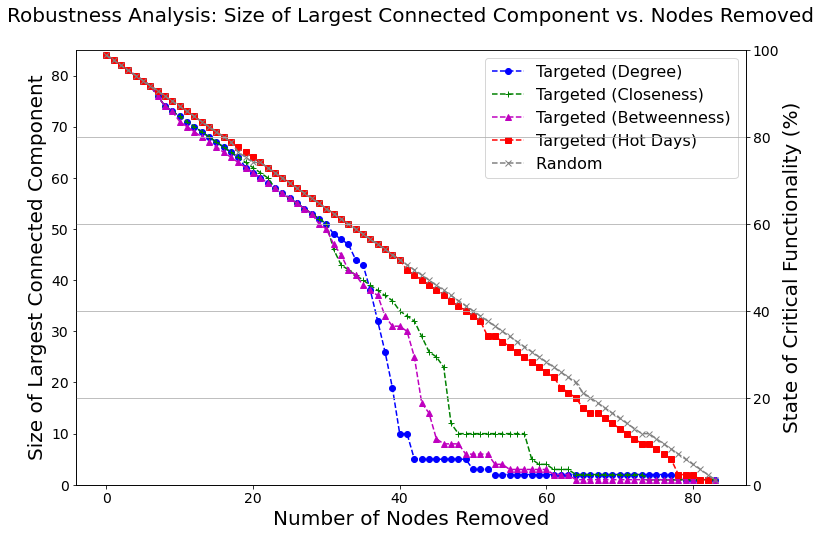

In [519]:
# Load the filtered edges CSV file
edges_file_path = f'{railonly_file_path}'
edges = pd.read_csv(edges_file_path)

# Construct the graph using NetworkX
G = nx.Graph()
edges_array = edges[['dms_orig_string', 'dms_dest_string', 'distance_miles']].values
G.add_weighted_edges_from(edges_array)

# Degree robustness function
def degree_robust_remove(G):
    G = G.copy()
    Gc_d = []
    removed = []
    for i in range(len(G)):
        node_deg = list(G.degree())
        if not node_deg:
            break
        gc = max(nx.connected_components(G), key=len)
        Gc_d.append(len(gc))
        target = max(node_deg, key=lambda x: x[1])[0]
        G.remove_node(target)
        removed.append(target)
    return Gc_d, removed,G

# Random removal robustness function
def degree_robust_rand(G):
    G = G.copy()
    Gc_dr = []
    removed = []
    for i in range(len(G)):
        node_deg = list(G.degree())
        if not node_deg:
            break
        gc = max(nx.connected_components(G), key=len)
        Gc_dr.append(len(gc))
        # Random removal
        target = random.choice(list(G.nodes()))
        G.remove_node(target)
        removed.append(target)
    return Gc_dr, removed, G


# Random removal robustness function
def degree_hot_days(G, remove_nodes_sorted):
    G_test = G.copy()
    Gc_d_hw = []
    removed_hw = []
    gc = max(nx.connected_components(G_test), key=len)
    Gc_d_hw.append(len(gc))
    for node_hw in remove_nodes_sorted:
        try:
            G_test.remove_node(node_hw)
            removed_hw.append(node_hw)
            gc = max(nx.connected_components(G_test), key=len)
            Gc_d_hw.append(len(gc))
        except:
            pass
    return Gc_d_hw, removed_hw, G_test

# Execute degree robustness analysis
Gc_d, removed_degree, G_updated_degree = degree_robust_remove(G)
print("Degree robustness (size of largest connected component after each removal):", Gc_d)
print("Nodes removed in order:", removed)

# Execute random robustness analysis
Gc_dr,removed_random,G_updated_random = degree_robust_rand(G)
print("Random removal robustness (size of largest connected component after each removal):", Gc_dr)


# Execute Hot days robustness analysis
Gc_d_hw,removed_hw,G_updated_hw = degree_hot_days(G,remove_nodes_sorted)
print("Random removal robustness (nodes with largest increase in hot days removed first):", Gc_d_hw)    


#Closeness
closeness_c = nx.closeness_centrality(G)
temp = sorted(closeness_c.items(), key=lambda kv: kv[1], reverse=True)
sorted_nodes_by_closeness = [i[0] for i in temp]

# Execute closeness robustness analysis
Gc_close,removed_close, G_updated_close = degree_hot_days(G,sorted_nodes_by_closeness)

# Betweenness Centrality
betweenness_c = nx.betweenness_centrality(G)
temp = sorted(betweenness_c.items(), key=lambda kv: kv[1], reverse=True)
sorted_nodes_by_betweenness = [i[0] for i in temp]

# Execute closeness robustness analysis
Gc_bw,removed_bw, G_updated_bw = degree_hot_days(G,sorted_nodes_by_betweenness)

    

# Combined plot : plt.subplots()
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(Gc_d, marker='o', linestyle='--', color='b', label='Targeted (Degree)')
ax.plot(Gc_close, marker='+', linestyle='--', color='g', label='Targeted (Closeness)')
ax.plot(Gc_bw, marker='^', linestyle='--', color='m', label='Targeted (Betweenness)')
#plt.plot(Gc_pre, marker='^', linestyle='-', color='g', label='Degree Preserving Randomization')
#plt.plot(Gc_sa, marker='s', linestyle='-', color='m', label='Removal of San Antonio TX(heat wave)')
ax.plot(Gc_d_hw, marker='s', linestyle='--', color='r', label='Targeted (Hot Days)')
ax.plot(Gc_dr, marker='x', linestyle='--', color='gray', label='Random ')
ax.set_xlabel('Number of Nodes Removed', fontsize=20)
ax.set_ylabel('Size of Largest Connected Component', fontsize=20)
ax.set_ylim(0,85)
# Create a secondary y-axis
ax2 = ax.twinx()
#y_ticks = ax.get_yticks()
#yy_ticks = [f"{a} %" for a in np.asarray(y_ticks *100/np.max(Gc_d), int)]
#yy_ticks = np.asarray(y_ticks *100/np.max(Gc_d), int)
#ax2.set_yticks(yy_ticks)
ax2.set_yticks(np.asarray(ax2.get_yticks() *100))
ax2.set_ylabel('State of Critical Functionality (%)', fontsize=20)

plt.title('Robustness Analysis: Size of Largest Connected Component vs. Nodes Removed\n', fontsize=20)
ax.legend(fontsize=16)
# Increase the font size of tick labels
ax.tick_params(axis='both', which='major', labelsize=14)
ax2.tick_params(axis='both', which='major', labelsize=14)
plt.grid(True)

fig.savefig( f'plots/Failure_Rail_DCBHR.pdf',bbox_inches='tight')
fig.savefig( f'plots/Failure_Rail_DCBHR.png',bbox_inches='tight')
plt.show()


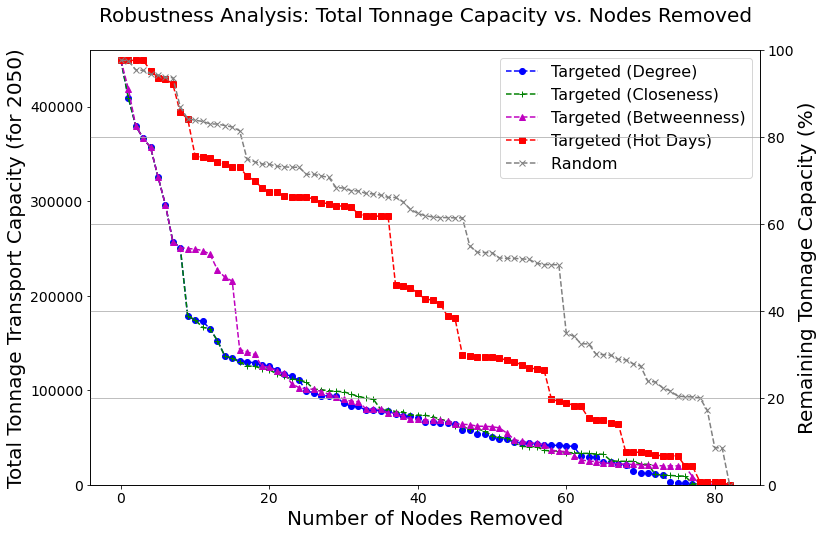

In [520]:
# Calclulation of tons
tonnage_year = '2050'
tons_data_rail = edges[['dms_orig_string', f'tons_{tonnage_year}']]
# Group by 'dms_orig_string' and sum the 'tons_2050' values
grouped_tons_rail = tons_data_rail.groupby('dms_orig_string')[f'tons_{tonnage_year}'].sum().reset_index()
total_tonnage_2050 = grouped_tons_rail[f'tons_{tonnage_year}'].sum()


def tonnage_loss (grouped_tons_rail, removed_degree):
    df = grouped_tons_rail.copy(deep=True)
    new_sum = df[f'tons_{tonnage_year}'].sum()
    cum_tonnage = [new_sum]
    for node_r in removed_degree:
        try:
            row = df[df['dms_orig_string'] == node_r].index[0]
            df = df.drop(row)
            # Calculate the new sum
            new_sum = df[f'tons_{tonnage_year}'].sum()
            cum_tonnage.append(new_sum)
        except:
            pass
    return cum_tonnage

cum_tonnage_degree = tonnage_loss (grouped_tons_rail, removed_degree)
cum_tonnage_random = tonnage_loss (grouped_tons_rail, removed_random)
cum_tonnage_hw = tonnage_loss (grouped_tons_rail, removed_hw)
cum_tonnage_bw = tonnage_loss (grouped_tons_rail, sorted_nodes_by_betweenness)
cum_tonnage_close = tonnage_loss (grouped_tons_rail, sorted_nodes_by_closeness)


# Combined plot : plt.subplots()
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(cum_tonnage_degree, marker='o', linestyle='--', color='b', label='Targeted (Degree)')
ax.plot(cum_tonnage_close, marker='+', linestyle='--', color='g', label='Targeted (Closeness)')
ax.plot(cum_tonnage_bw, marker='^', linestyle='--', color='m', label='Targeted (Betweenness)')
ax.plot(cum_tonnage_hw, marker='s', linestyle='--', color='r', label='Targeted (Hot Days)')
ax.plot(cum_tonnage_random, marker='x', linestyle='--', color='gray', label='Random ')

ax.set_xlabel('Number of Nodes Removed', fontsize=20)
ax.set_ylabel(f'Total Tonnage Transport Capacity (for {tonnage_year})', fontsize=20)
ax.set_ylim(0,460000)
# Create a secondary y-axis
ax2 = ax.twinx()
#y_ticks = ax.get_yticks()
#yy_ticks = [f"{a} %" for a in np.asarray(y_ticks *100/np.max(Gc_d), int)]
#yy_ticks = np.asarray(y_ticks *100/np.max(Gc_d), int)
#ax2.set_yticks(yy_ticks)
ax2.set_yticks(np.asarray(ax2.get_yticks() *100))
ax2.set_ylabel('Remaining Tonnage Capacity (%)', fontsize=20)

plt.title('Robustness Analysis: Total Tonnage Capacity vs. Nodes Removed\n', fontsize=20)
ax.legend(fontsize=16)
# Increase the font size of tick labels
ax.tick_params(axis='both', which='major', labelsize=14)
ax2.tick_params(axis='both', which='major', labelsize=14)
plt.grid(True)

fig.savefig( f'plots/Failure_Tonnage_Rail_DCBHR.pdf',bbox_inches='tight')
fig.savefig( f'plots/Failure_Tonnage_Rail_DCBHR.png',bbox_inches='tight')
plt.show()


In [527]:
wateronly_file_path = 'wateronly.csv'

In [528]:
# 6, 20, 25,30 # tested till 50
random.seed(25)

Degree robustness (size of largest connected component after each removal): [42, 39, 36, 34, 28, 23, 13, 10, 8, 8, 7, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Nodes removed in order: ['Houston TX', 'Iowa', 'Chicago IL-IN-WI (IL Part)', 'Los Angeles CA', 'Baton Rouge LA', 'New Orleans LA-MS (LA Part)', 'Wyoming', 'Atlanta GA', 'Detroit MI', 'Fort Wayne IN', 'Cleveland OH', 'Minneapolis-St. Paul MN-WI (MN Part)', 'Beaumont TX', 'San Francisco CA', 'Philadelphia PA-NJ-DE-MD (PA Part)', 'Portland OR-WA (OR Part)', 'Tampa FL', 'Philadelphia PA-NJ-DE-MD (NJ Part)', 'Indianapolis IN', 'Baltimore MD', 'Salt Lake City UT', 'Chicago IL-IN-WI (IN Part)', 'Columbus OH', 'Birmingham AL', 'New York NY-NJ-CT-PA (NY Part)', 'Charleston SC', 'Memphis TN-MS-AR (TN Part)', 'New York NY-NJ-CT-PA (NJ Part)', 'Charlotte NC-SC (NC Part)', 'Omaha NE-IA (NE Part)', 'Pittsburgh PA-OH-WV (PA Part)', 'St. Louis MO-IL (MO Part)', 'Jacksonville FL-G

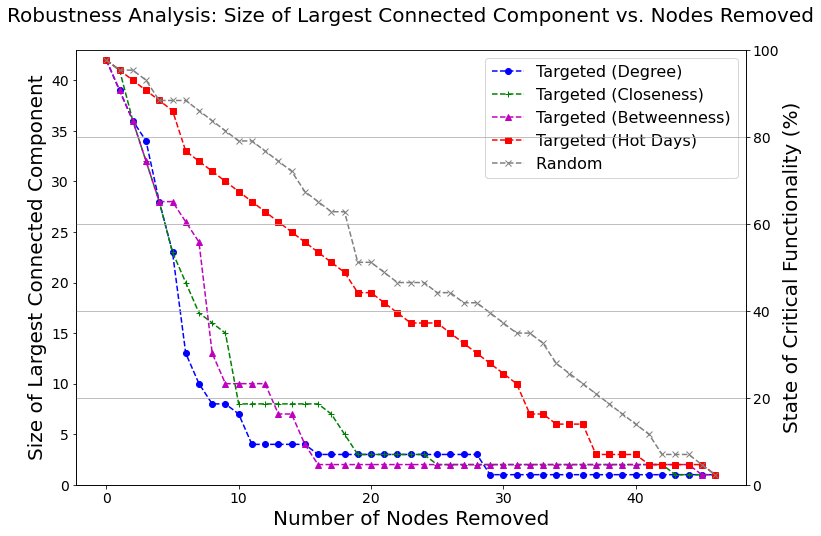

In [529]:
# Load the filtered edges CSV file
edges_file_path = f'{wateronly_file_path}'
edges = pd.read_csv(edges_file_path)

# Construct the graph using NetworkX
G = nx.Graph()
edges_array = edges[['dms_orig_string', 'dms_dest_string', 'distance_miles']].values
G.add_weighted_edges_from(edges_array)

# Degree robustness function
def degree_robust_remove(G):
    G = G.copy()
    Gc_d = []
    removed = []
    for i in range(len(G)):
        node_deg = list(G.degree())
        if not node_deg:
            break
        gc = max(nx.connected_components(G), key=len)
        Gc_d.append(len(gc))
        target = max(node_deg, key=lambda x: x[1])[0]
        G.remove_node(target)
        removed.append(target)
    return Gc_d, removed,G

# Random removal robustness function
def degree_robust_rand(G):
    G = G.copy()
    Gc_dr = []
    removed = []
    for i in range(len(G)):
        node_deg = list(G.degree())
        if not node_deg:
            break
        gc = max(nx.connected_components(G), key=len)
        Gc_dr.append(len(gc))
        # Random removal
        target = random.choice(list(G.nodes()))
        G.remove_node(target)
        removed.append(target)
    return Gc_dr, removed, G


# Random removal robustness function
def degree_hot_days(G, remove_nodes_sorted):
    G_test = G.copy()
    Gc_d_hw = []
    removed_hw = []
    gc = max(nx.connected_components(G_test), key=len)
    Gc_d_hw.append(len(gc))
    for node_hw in remove_nodes_sorted:
        try:
            G_test.remove_node(node_hw)
            removed_hw.append(node_hw)
            gc = max(nx.connected_components(G_test), key=len)
            Gc_d_hw.append(len(gc))
        except:
            pass
    return Gc_d_hw, removed_hw, G_test


# Execute degree robustness analysis
Gc_d, removed_degree, G_updated_degree = degree_robust_remove(G)
print("Degree robustness (size of largest connected component after each removal):", Gc_d)
print("Nodes removed in order:", removed)

# Execute random robustness analysis
Gc_dr,removed_random,G_updated_random = degree_robust_rand(G)
print("Random removal robustness (size of largest connected component after each removal):", Gc_dr)


# Execute Hot days robustness analysis
Gc_d_hw,removed_hw,G_updated_hw = degree_hot_days(G,remove_nodes_sorted)
print("Random removal robustness (nodes with largest increase in hot days removed first):", Gc_d_hw)    

#Closeness
closeness_c = nx.closeness_centrality(G)
temp = sorted(closeness_c.items(), key=lambda kv: kv[1], reverse=True)
sorted_nodes_by_closeness = [i[0] for i in temp]

# Execute closeness robustness analysis
Gc_close,removed_close, G_updated_close = degree_hot_days(G,sorted_nodes_by_closeness)

# Betweenness Centrality
betweenness_c = nx.betweenness_centrality(G)
temp = sorted(betweenness_c.items(), key=lambda kv: kv[1], reverse=True)
sorted_nodes_by_betweenness = [i[0] for i in temp]

# Execute closeness robustness analysis
Gc_bw,removed_bw, G_updated_bw = degree_hot_days(G,sorted_nodes_by_betweenness)

    

# Combined plot : plt.subplots()
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(Gc_d, marker='o', linestyle='--', color='b', label='Targeted (Degree)')
ax.plot(Gc_close, marker='+', linestyle='--', color='g', label='Targeted (Closeness)')
ax.plot(Gc_bw, marker='^', linestyle='--', color='m', label='Targeted (Betweenness)')
#plt.plot(Gc_pre, marker='^', linestyle='-', color='g', label='Degree Preserving Randomization')
#plt.plot(Gc_sa, marker='s', linestyle='-', color='m', label='Removal of San Antonio TX(heat wave)')
ax.plot(Gc_d_hw, marker='s', linestyle='--', color='r', label='Targeted (Hot Days)')
ax.plot(Gc_dr, marker='x', linestyle='--', color='gray', label='Random ')
ax.set_xlabel('Number of Nodes Removed', fontsize=20)
ax.set_ylabel('Size of Largest Connected Component', fontsize=20)
ax.set_ylim(0,43)
# Create a secondary y-axis
ax2 = ax.twinx()
#y_ticks = ax.get_yticks()
#yy_ticks = [f"{a} %" for a in np.asarray(y_ticks *100/np.max(Gc_d), int)]
#yy_ticks = np.asarray(y_ticks *100/np.max(Gc_d), int)
#ax2.set_yticks(yy_ticks)
ax2.set_yticks(np.asarray(ax2.get_yticks() *100))
ax2.set_ylabel('State of Critical Functionality (%)', fontsize=20)

plt.title('Robustness Analysis: Size of Largest Connected Component vs. Nodes Removed\n', fontsize=20)
ax.legend(fontsize=16)
# Increase the font size of tick labels
ax.tick_params(axis='both', which='major', labelsize=14)
ax2.tick_params(axis='both', which='major', labelsize=14)
plt.grid(True)

fig.savefig( f'plots/Failure_Water_DCBHR.pdf',bbox_inches='tight')
fig.savefig( f'plots/Failure_Water_DCBHR.png',bbox_inches='tight')
plt.show()

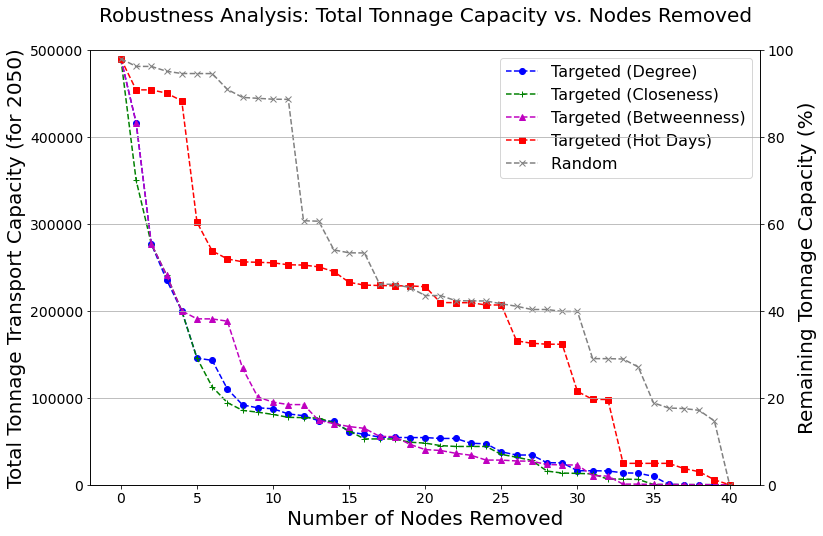

In [530]:
# Calclulation of tons
tonnage_year = '2050'
tons_data_rail = edges[['dms_orig_string', f'tons_{tonnage_year}']]
# Group by 'dms_orig_string' and sum the 'tons_2050' values
grouped_tons_rail = tons_data_rail.groupby('dms_orig_string')[f'tons_{tonnage_year}'].sum().reset_index()
total_tonnage_2050 = grouped_tons_rail[f'tons_{tonnage_year}'].sum()


def tonnage_loss (grouped_tons_rail, removed_degree):
    df = grouped_tons_rail.copy(deep=True)
    new_sum = df[f'tons_{tonnage_year}'].sum()
    cum_tonnage = [new_sum]
    for node_r in removed_degree:
        try:
            row = df[df['dms_orig_string'] == node_r].index[0]
            df = df.drop(row)
            # Calculate the new sum
            new_sum = df[f'tons_{tonnage_year}'].sum()
            cum_tonnage.append(new_sum)
        except:
            pass
    return cum_tonnage

cum_tonnage_degree = tonnage_loss (grouped_tons_rail, removed_degree)
cum_tonnage_random = tonnage_loss (grouped_tons_rail, removed_random)
cum_tonnage_hw = tonnage_loss (grouped_tons_rail, removed_hw)
cum_tonnage_bw = tonnage_loss (grouped_tons_rail, sorted_nodes_by_betweenness)
cum_tonnage_close = tonnage_loss (grouped_tons_rail, sorted_nodes_by_closeness)


# Combined plot : plt.subplots()
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(cum_tonnage_degree, marker='o', linestyle='--', color='b', label='Targeted (Degree)')
ax.plot(cum_tonnage_close, marker='+', linestyle='--', color='g', label='Targeted (Closeness)')
ax.plot(cum_tonnage_bw, marker='^', linestyle='--', color='m', label='Targeted (Betweenness)')
ax.plot(cum_tonnage_hw, marker='s', linestyle='--', color='r', label='Targeted (Hot Days)')
ax.plot(cum_tonnage_random, marker='x', linestyle='--', color='gray', label='Random ')


ax.set_xlabel('Number of Nodes Removed', fontsize=20)
ax.set_ylabel(f'Total Tonnage Transport Capacity (for {tonnage_year})', fontsize=20)
ax.set_ylim(0,500000)
# Create a secondary y-axis
ax2 = ax.twinx()
#y_ticks = ax.get_yticks()
#yy_ticks = [f"{a} %" for a in np.asarray(y_ticks *100/np.max(Gc_d), int)]
#yy_ticks = np.asarray(y_ticks *100/np.max(Gc_d), int)
#ax2.set_yticks(yy_ticks)
ax2.set_yticks(np.asarray(ax2.get_yticks() *100))
ax2.set_ylabel('Remaining Tonnage Capacity (%)', fontsize=20)

plt.title('Robustness Analysis: Total Tonnage Capacity vs. Nodes Removed\n', fontsize=20)
ax.legend(fontsize=16)
# Increase the font size of tick labels
ax.tick_params(axis='both', which='major', labelsize=14)
ax2.tick_params(axis='both', which='major', labelsize=14)
plt.grid(True)

fig.savefig( f'plots/Failure_Tonnage_Water_DCBHR.pdf',bbox_inches='tight')
fig.savefig( f'plots/Failure_Tonnage_Water_DCBHR.png',bbox_inches='tight')
plt.show()


In [525]:
def recovery_nodes(G, G_updated, removed_degrees):
    G = G_updated.copy()
    nodes_to_add = removed_random.copy()
    re_updated_G = G.copy()
    re_G_list = [len(re_updated_G)]
    for node in nodes_to_add:
        re_updated_G.add_node(node)
        re_updated_G.add_edges_from(list(G.edges(node)))
        re_G_list.append(len(re_updated_G))
    return re_updated_G, re_G_list

# Execute Recovery of random robustness analysis
_,re_G_list_rand = recovery_nodes(G, G_updated_random, removed_random)

# Execute Recovery of degree robustness analysis
_,re_G_list_degree = recovery_nodes(G, G_updated_degree, removed_degree)

# Execute Recovery of hot days robustness analysis
_,re_G_list_hw = recovery_nodes(G, G_updated_hw, removed_hw)

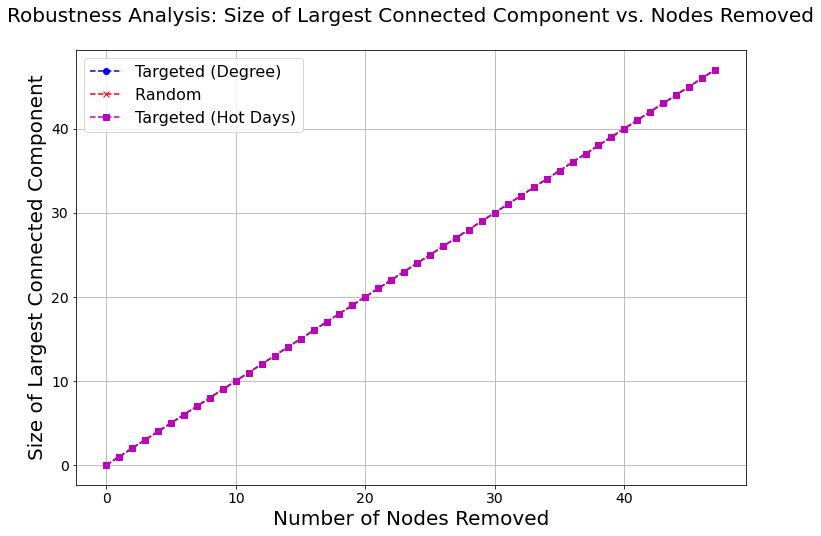

In [526]:
# Combined plot
plt.figure(figsize=(12, 8))
plt.plot(re_G_list_degree, marker='o', linestyle='--', color='b', label='Targeted (Degree)')
plt.plot(re_G_list_rand, marker='x', linestyle='--', color='r', label='Random ')
plt.plot(re_G_list_hw, marker='s', linestyle='--', color='m', label='Targeted (Hot Days)')
plt.xlabel('Number of Nodes Removed', fontsize=20)
plt.ylabel('Size of Largest Connected Component', fontsize=20)
plt.title('Robustness Analysis: Size of Largest Connected Component vs. Nodes Removed\n', fontsize=20)
plt.legend(fontsize=16)
# Increase the font size of tick labels
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(True)
plt.show()
